In [1]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
from collections import defaultdict

# --- Plotting Style Configuration ---
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 14

# --- Analysis Configuration ---
os.chdir('/Users/leodrake/Documents/MIT/ss433/HRC_2024/2Dfits/')
CENTER_PIXEL = 80.5
PIXSCALE_ARCSEC = 0.13175/4  # arcsec per pixel
G1_COMPONENT = 'g1'
FILE_PATH = 'component tracking results/tracker-4comp-1sigma-jittercorr-empPSF-000000-160160.txt'

In [2]:
def parse_observations_optimized(filename):
    """
    Parses repeated ‘Observation:’ blocks from a file, optimized for
    readability and efficiency.
    """
    # Regex patterns are compiled once for performance.
    # Using re.VERBOSE (via triple quotes) makes complex regex easier to read.
    blk_re = re.compile(r"^(Observation:\s*(?P<obs_id>\d+))(?P<body>.*?)(?=^Observation:|\Z)", re.S | re.M)
    date_re = re.compile(r"^\s*Date:\s*([\d\.]+)\s*,\s*Exptime:\s*([\d\.]+)", re.M)
    rate_re = re.compile(r"^\s*(?P<comp>g\d+)\s*:\s*(?P<nom>[\d.eE+-]+)\s*\((?P<e1>[+-]?[\d.eE+-]+)\s*/\s*(?P<e2>[+-]?[\d.eE+-]+)\)", re.M)
    # MODIFIED REGEX: Allows for '-------' in the error columns
    param_re = re.compile(r"^\s*(?P<comp>g\d+)\.(?P<param>xpos|ypos|ampl|fwhm)\s+([\d.eE+-]+)\s+([+-]?[\d.eE+-]+|-------)\s+([+-]?[\d.eE+-]+|-------)", re.M)

    try:
        with open(filename, 'r') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: File not found at {filename}")
        return pd.DataFrame()

    rows = []
    for m_blk in blk_re.finditer(text):
        obs_id = int(m_blk.group('obs_id'))
        body = m_blk.group('body')
        
        mjd, exptime = (float(m.group(1)), float(m.group(2))) if (m := date_re.search(body)) else (np.nan, np.nan)

        pdat = defaultdict(dict)
        for pm in param_re.finditer(body):
            comp, param, best, lower_str, upper_str = pm.groups()
            pdat[comp][param] = float(best)

            # --- FIX STARTS HERE ---
            # Try to convert error bounds to float; if it fails, use np.nan
            try:
                pdat[comp][f'{param}_minus'] = abs(float(lower_str))
            except ValueError:
                pdat[comp][f'{param}_minus'] = np.nan
            
            try:
                pdat[comp][f'{param}_plus'] = abs(float(upper_str))
            except ValueError:
                pdat[comp][f'{param}_plus'] = np.nan
            # --- FIX ENDS HERE ---

        for rm in rate_re.finditer(body):
            comp, nom, e1_str, e2_str = rm.groups()
            e1, e2 = float(e1_str), float(e2_str)
            minus_err, plus_err = (abs(e1), abs(e2)) if e1 < 0 else (abs(e2), abs(e1))

            row = {
                'obs_id': obs_id, 'mjd': mjd, 'exptime': exptime, 'component': comp,
                'nominal': float(nom), 'plus_err': plus_err, 'minus_err': minus_err,
                **pdat.get(comp, {})
            }
            rows.append(row)

    if not rows:
        return pd.DataFrame()

    df = pd.DataFrame(rows)
    if df['mjd'].isna().all():
        df['mjd'] = df['obs_id'].astype('category').cat.codes

    return df

In [3]:
# --- Load Data ---
df = parse_observations_optimized(FILE_PATH) # Assumes the optimized function from before

# --- Vectorized Recenter on g1 ---
# Create a map of observation IDs to their g1 offsets
g1_pos = df[df['component'] == G1_COMPONENT].set_index('obs_id')[['xpos', 'ypos']].to_dict('index')
df['dx'] = df['obs_id'].map(lambda i: g1_pos.get(i, {}).get('xpos', CENTER_PIXEL)) - CENTER_PIXEL
df['dy'] = df['obs_id'].map(lambda i: g1_pos.get(i, {}).get('ypos', CENTER_PIXEL)) - CENTER_PIXEL

# Apply the displacement to all components
df['xpos'] -= df['dx']
df['ypos'] -= df['dy']
df.drop(columns=['dx', 'dy'], inplace=True)

# --- Calculate Offsets, PA, Radius, and Propagate Errors ---
df['xoff'] = df['xpos'] - CENTER_PIXEL
df['yoff'] = df['ypos'] - CENTER_PIXEL

pa_rad = np.arctan2(-df['xoff'], df['yoff'])
df['PA'] = np.degrees(pa_rad)

d2 = df['xoff']**2 + df['yoff']**2
dPA_dx = np.divide(-df['yoff'], d2, out=np.full_like(d2, np.nan), where=d2 != 0)
dPA_dy = np.divide(df['xoff'], d2, out=np.full_like(d2, np.nan), where=d2 != 0)

df['PA_err_plus'] = np.degrees(np.sqrt((dPA_dx * df['xpos_plus'])**2 + (dPA_dy * df['ypos_plus'])**2))
df['PA_err_minus'] = np.degrees(np.sqrt((dPA_dx * df['xpos_minus'])**2 + (dPA_dy * df['ypos_minus'])**2))

df['radius'] = np.hypot(df['xoff'], df['yoff']) * PIXSCALE_ARCSEC

r_pix = df['radius'] / PIXSCALE_ARCSEC
is_zero = np.isclose(r_pix, 0)
df['radius_plus_err'] = np.where(is_zero, np.hypot(df['xpos_plus'], df['ypos_plus']), np.sqrt((df['xoff']*df['xpos_plus'])**2 + (df['yoff']*df['ypos_plus'])**2)/r_pix) * PIXSCALE_ARCSEC
df['radius_minus_err'] = np.where(is_zero, np.hypot(df['xpos_minus'], df['ypos_minus']), np.sqrt((df['xoff']*df['xpos_minus'])**2 + (df['yoff']*df['ypos_minus'])**2)/r_pix) * PIXSCALE_ARCSEC

# --- Add a 'flag' column for suspect data ---
# First, ensure data is sorted by time to correctly identify the first three observations
df.sort_values('mjd', inplace=True)

# Get the unique obs_ids of the first three observations
first_three_obs_ids = df['obs_id'].unique()[:3]

# Initialize the flag column with a default 'clean' value
df['flag'] = 'clean'

# Create a mask to identify g2 components within the first three observations
flag_mask = (df['component'] == 'g2') & (df['obs_id'].isin(first_three_obs_ids))

# Apply the flag to the identified rows
df.loc[flag_mask, 'flag'] = 'flagged_g2_suspect'
print(f"Flagged {len(first_three_obs_ids)} observations for component 'g2'.")

# --- Pivot Data and Save ---
# Get the number of components *before* pivoting to create the filename
n_comps = df['component'].nunique()
output_csv_filename = f'gaussian-component-data-{n_comps}-comps-1sigma-jittercorr-0000-4040.csv'

# Now, perform the pivot operation
pivoted = df.pivot_table(index='mjd', columns='component', values=['nominal', 'plus_err', 'minus_err'])
df_nom, df_plus, df_minus = [pivoted[val].sort_index() for val in ['nominal', 'plus_err', 'minus_err']]

# Save the main DataFrame to the new dynamic filename
df.to_csv(output_csv_filename, index=False)
print(f"DataFrame with {n_comps} components saved to {output_csv_filename}")

Flagged 3 observations for component 'g2'.
DataFrame with 4 components saved to gaussian-component-data-4-comps-1sigma-jittercorr-0000-4040.csv


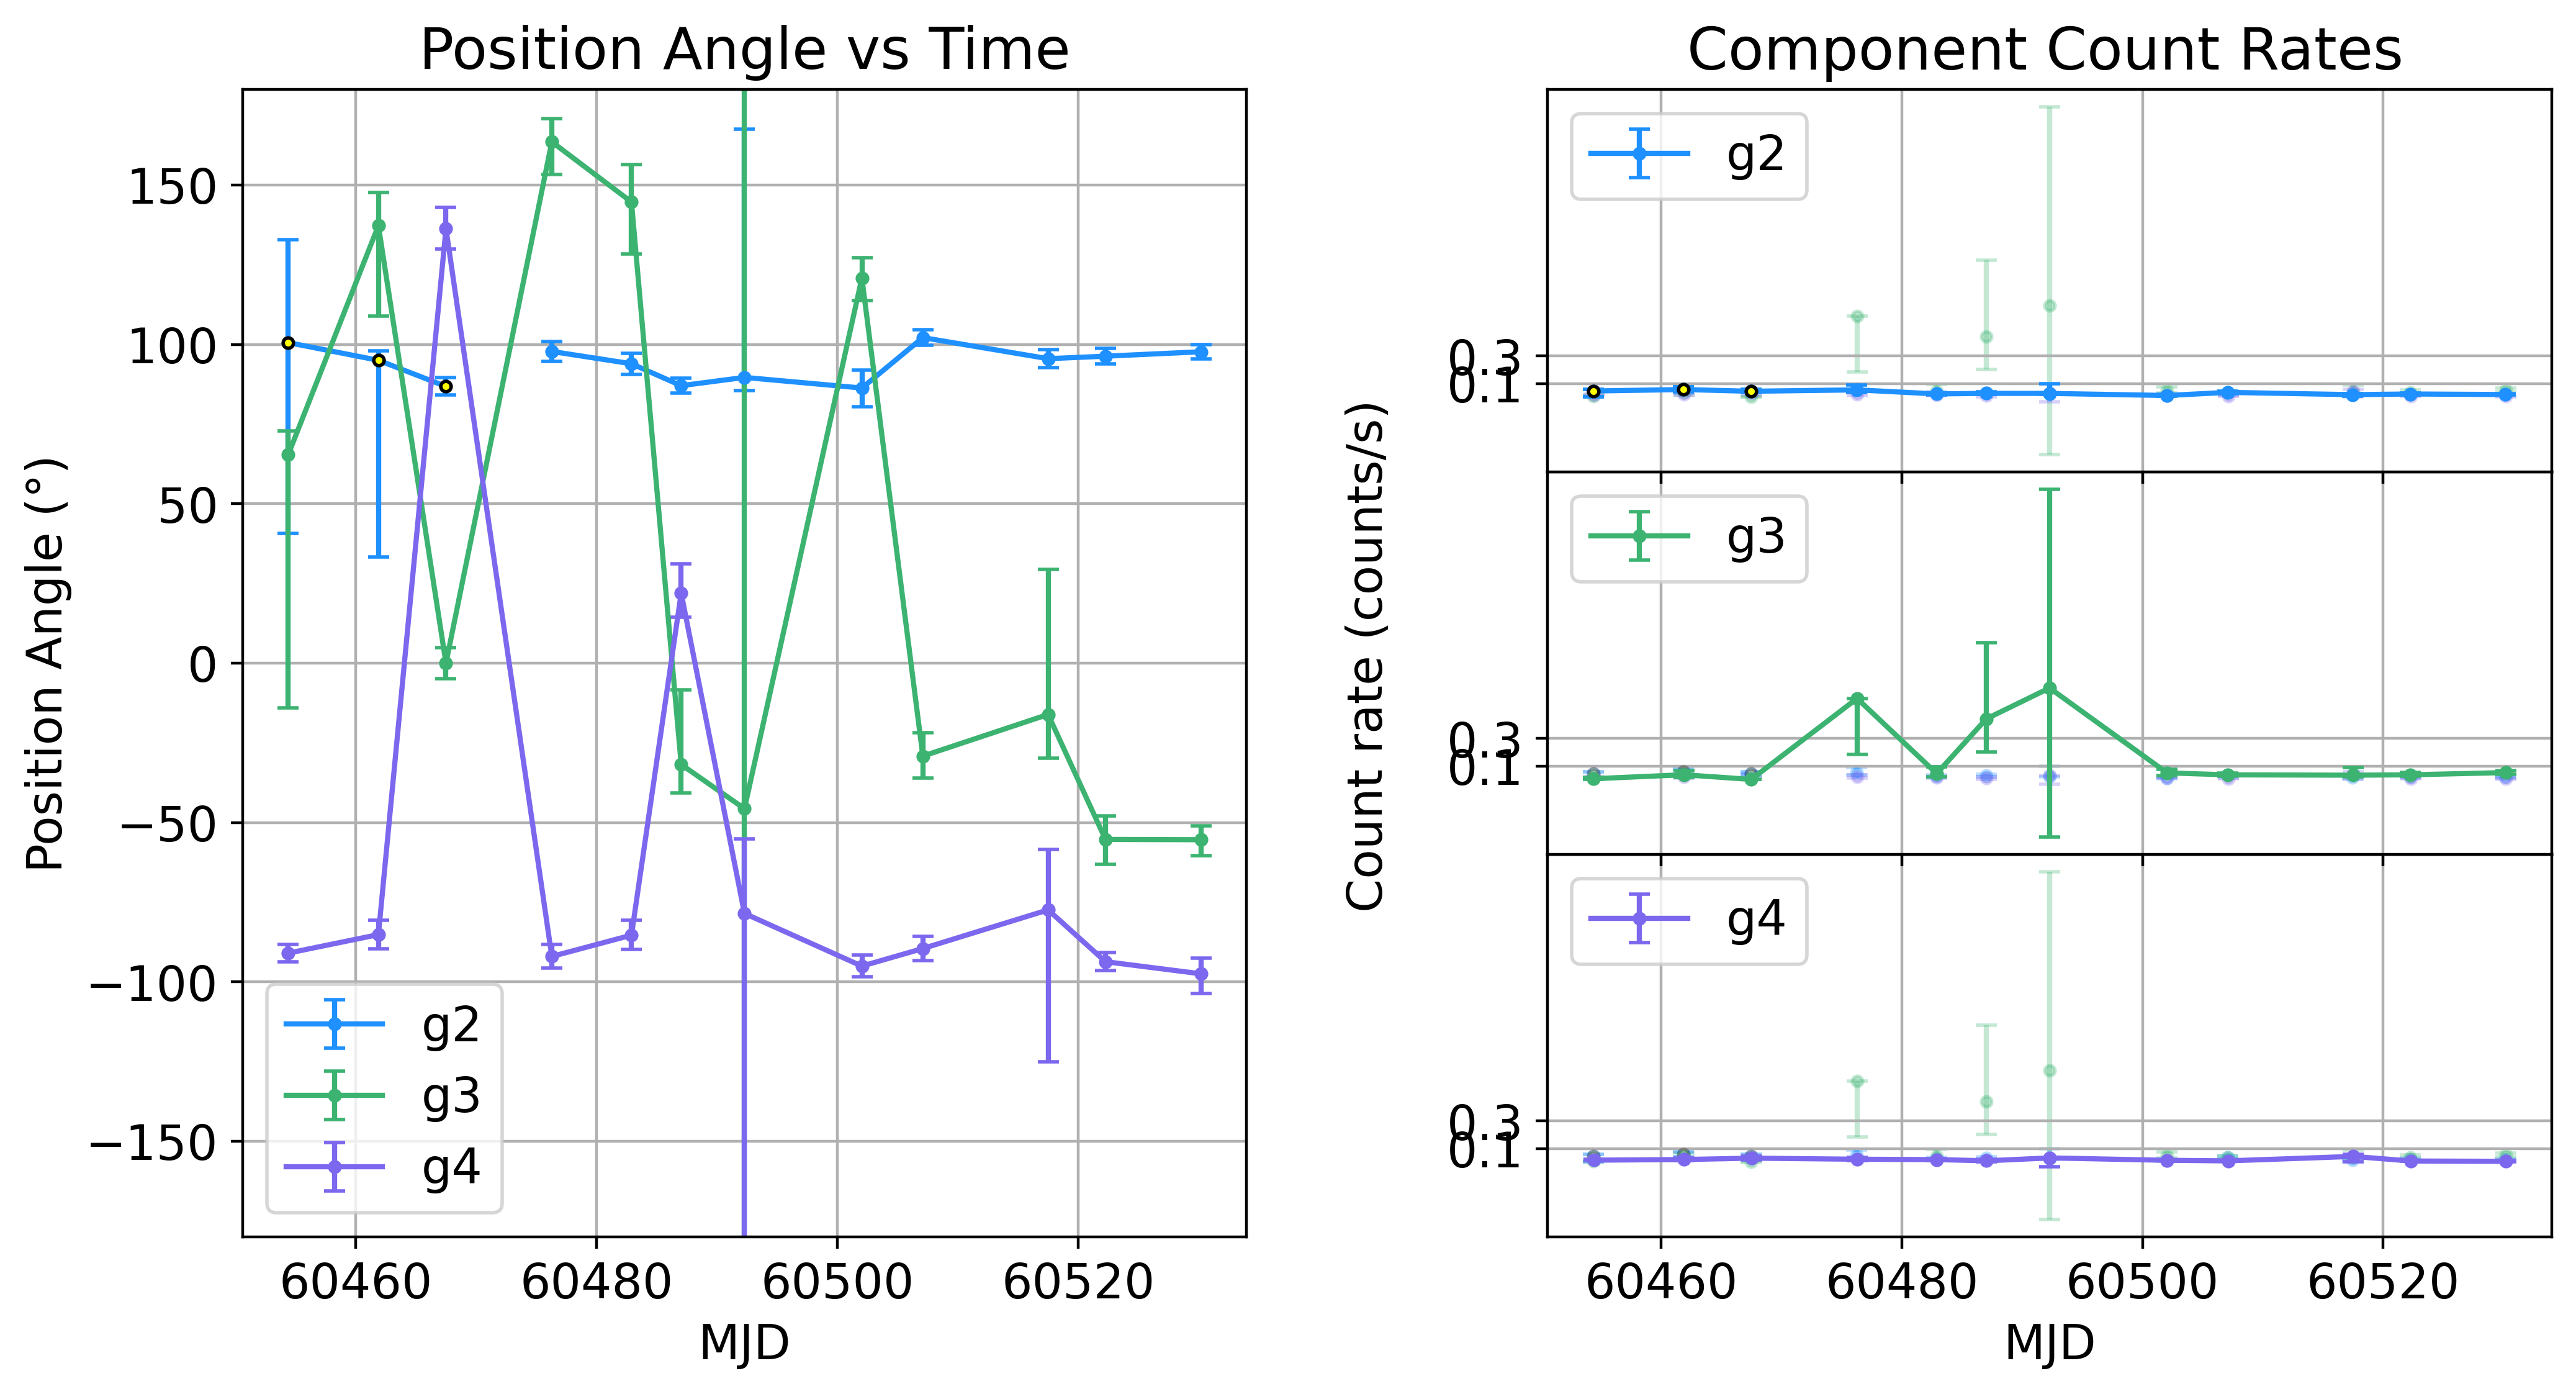

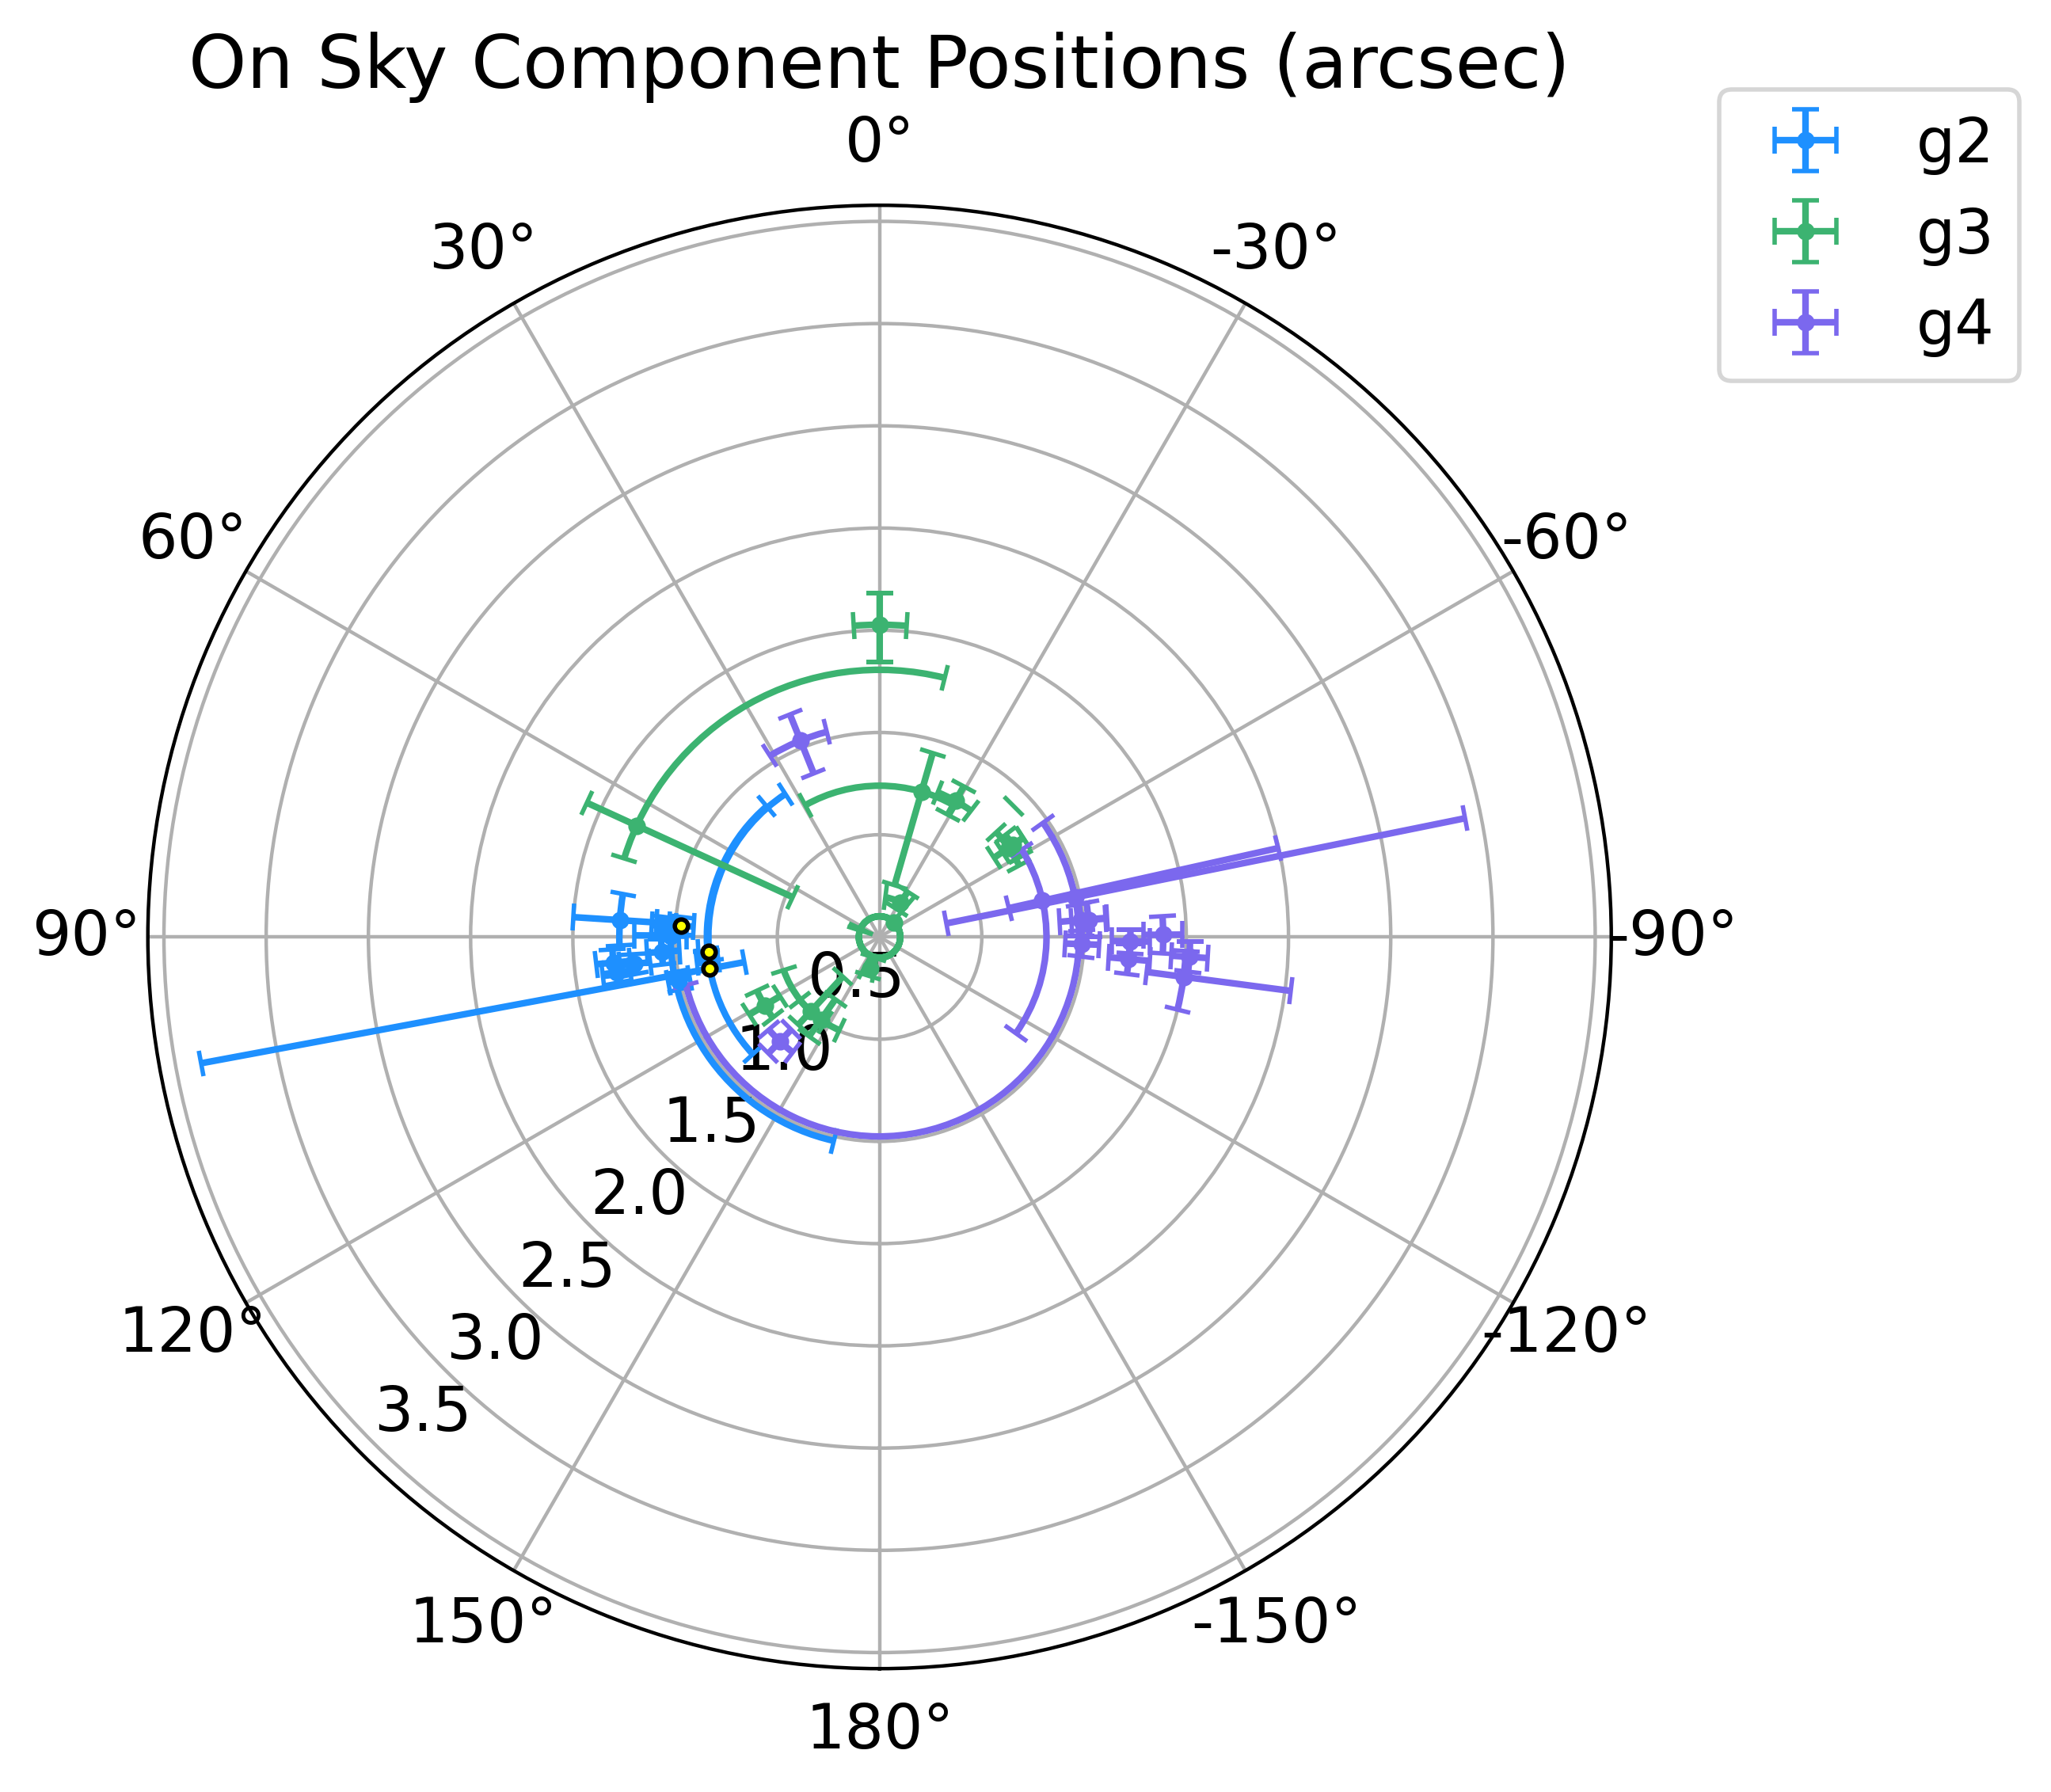

In [4]:
grouped_by_comp = df.groupby('component')

# Create a dictionary to map components to colors
comps = [c for c in df_nom.columns if c != 'g1']
colors = ['dodgerblue', 'mediumseagreen',  'mediumslateblue','lightcoral']
comp_colors = {comp: colors[i % len(colors)] for i, comp in enumerate(comps)}

n = len(comps)
delta = 0.02
offsets = {c: (i - (n - 1) / 2) * delta for i, c in enumerate(comps)}

with PdfPages(f'position-rates-plots-{n+1}comp-1sigma-jittercorr-0000-4040.pdf') as pdf:
    # First figure: PA vs time + stacked count rates
    fig = plt.figure(figsize=(12, 6))
    gs  = GridSpec(n, 2, figure=fig, width_ratios=[1,1], hspace=0, wspace=0.3)

    # Left: PA vs time
    ax_pa = fig.add_subplot(gs[:,0])
    for comp, color in comp_colors.items():
        if comp in grouped_by_comp.groups:
            grp = grouped_by_comp.get_group(comp)
            if comp == 'g2':
                # Split g2 data into clean and flagged sets
                clean_grp = grp[grp['flag'] == 'clean']
                flagged_grp = grp[grp['flag'] != 'clean']
                
                # Plot clean g2 points
                if not clean_grp.empty:
                    ax_pa.errorbar(
                        clean_grp['mjd'], clean_grp['PA'],
                        yerr=[clean_grp['PA_err_minus'], clean_grp['PA_err_plus']],
                        marker='.', linestyle='-', capsize=3, color=color, label=comp
                    )
                # Plot flagged g2 points in yellow
                if not flagged_grp.empty:
                    ax_pa.errorbar(
                        flagged_grp['mjd'], flagged_grp['PA'],
                        yerr=[flagged_grp['PA_err_minus'], flagged_grp['PA_err_plus']],
                        marker='.', linestyle='-', capsize=3, color='dodgerblue', 
                        markerfacecolor='yellow', markeredgecolor='k', label=None
                    )
            else:
                # Plot all other components as normal
                ax_pa.errorbar(
                    grp['mjd'], grp['PA'],
                    yerr=[grp['PA_err_minus'], grp['PA_err_plus']],
                    marker='.', linestyle='-', capsize=3, color=color, label=comp
                )
    ax_pa.set_ylabel('Position Angle (°)')
    ax_pa.set_xlabel('MJD')
    ax_pa.set_title('Position Angle vs Time')
    ax_pa.set_ylim(-180,180)
    ax_pa.grid(True)
    ax_pa.legend()

    # Right: stacked count-rate panels
    ax_bottom = None
    flagged_mjds = df.loc[df['flag'] != 'clean', 'mjd'].unique()
    for i_comp, focus in reversed(list(enumerate(comps))):
        if i_comp == n - 1:
            ax = fig.add_subplot(gs[i_comp, 1])
            ax.set_xlabel('MJD')
            ax_bottom = ax
        else:
            ax = fig.add_subplot(gs[i_comp, 1], sharex=ax_bottom)
            ax.tick_params(labelbottom=False)
        ax.grid(True, zorder=0)
        for comp_name, current_color in comp_colors.items():
            x_val = df_nom.index + offsets[comp_name]
            y_val = df_nom[comp_name]
            y_err_val = [df_minus[comp_name], df_plus[comp_name]]
            alpha_val, line_style, label_text, z_order = (1.0, '-', comp_name, 10) if comp_name == focus else (0.3, '', None, 1)
            ax.errorbar(
                x_val, y_val, yerr=y_err_val, color=current_color,
                marker='.', linestyle=line_style, capsize=3,
                alpha=alpha_val, label=label_text, zorder=z_order
            )
            # Overlay flagged g2 points if this is the g2 component
            if comp_name == 'g2' and len(flagged_mjds) > 0:
                # Select the flagged data from the pivoted DataFrames
                x_flagged = df_nom.loc[flagged_mjds].index + offsets[comp_name]
                y_flagged = df_nom.loc[flagged_mjds, comp_name]
                y_err_flagged = [df_minus.loc[flagged_mjds, comp_name], df_plus.loc[flagged_mjds, comp_name]]
                ax.errorbar(
                    x_flagged, y_flagged, yerr=y_err_flagged,
                    marker='.', linestyle='', capsize=3, color='dodgerblue',
                    markerfacecolor='yellow', markeredgecolor='k', zorder=z_order+1,
                    alpha=alpha_val # <-- THIS IS THE FIX
                )
        ax.set_yticks([0.1,0.3])
        if ax.has_data():
             ax.legend(loc='upper left')

    fig.text(0.73, 0.885, 'Component Count Rates', ha='center', va='bottom', fontsize=17)
    fig.text(0.495, 0.5, 'Count rate (counts/s)', va='center', rotation='vertical')
    
    pdf.savefig(fig)
    plt.show()

    # Second figure: polar plot of PA on sky
    fig_polar = plt.figure(figsize=(8,6))
    ax_polar = fig_polar.add_subplot(111, projection='polar')
    ax_polar.set_theta_zero_location('N')
    ax_polar.set_theta_direction(1)
    ax_polar.set_thetamin(-180)
    ax_polar.set_thetamax(180)
    ax_polar.set_rlabel_position(135)

    for comp, color in comp_colors.items():
        if comp in grouped_by_comp.groups:
            grp = grouped_by_comp.get_group(comp)
            if comp == 'g2':
                clean_grp = grp[grp['flag'] == 'clean']
                flagged_grp = grp[grp['flag'] != 'clean']
                
                # Plot clean g2 points
                if not clean_grp.empty:
                    ax_polar.errorbar(
                        np.deg2rad(clean_grp['PA']), clean_grp['radius'],
                        xerr=[np.deg2rad(clean_grp['PA_err_minus'].fillna(0)), np.deg2rad(clean_grp['PA_err_plus'].fillna(0))],
                        yerr=[clean_grp['radius_minus_err'].fillna(0), clean_grp['radius_plus_err'].fillna(0)],
                        marker='.', linestyle='', color=color, capsize=3, label=comp
                    )
                # Plot flagged g2 points
                if not flagged_grp.empty:
                    ax_polar.errorbar(
                        np.deg2rad(flagged_grp['PA']), flagged_grp['radius'],
                        xerr=[np.deg2rad(flagged_grp['PA_err_minus'].fillna(0)), np.deg2rad(flagged_grp['PA_err_plus'].fillna(0))],
                        yerr=[flagged_grp['radius_minus_err'].fillna(0), flagged_grp['radius_plus_err'].fillna(0)],
                        marker='.', linestyle='', color='dodgerblue', capsize=3, label=None,
                        markerfacecolor='yellow', markeredgecolor='k'
                    )
            else:
                # Plot other components as normal
                ax_polar.errorbar(
                    np.deg2rad(grp['PA']), grp['radius'],
                    xerr=[np.deg2rad(grp['PA_err_minus'].fillna(0)), np.deg2rad(grp['PA_err_plus'].fillna(0))],
                    yerr=[grp['radius_minus_err'].fillna(0), grp['radius_plus_err'].fillna(0)],
                    marker='.', linestyle='', color=color, capsize=3, label=comp
                )

    angles = np.arange(-150, 180, 30)
    angles = np.append(angles, 180)
    ax_polar.set_rmin(0)
    ax_polar.set_thetagrids(angles, [f"{int(a)}°" for a in angles])
    ax_polar.set_title('On Sky Component Positions (arcsec)')
    ax_polar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    pdf.savefig(fig_polar)
    plt.show()